In [ ]:
! pip -q install transformers

     |████████████████████████████████| 5.8 MB 22.9 MB/s 
     |████████████████████████████████| 182 kB 70.1 MB/s 
     |████████████████████████████████| 7.6 MB 61.2 MB/s 


In [ ]:
! pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 14.9 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 84 kB 4.7 MB/s 
     |████████████████████████████████| 278 kB 65.6 MB/s 
     |████████████████████████████████| 2.3 MB 77.2 MB/s 
     |████████████████████████████████| 106 kB 86.4 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 80 kB 6.7 MB/s 
     |████████████████████████████████| 69 kB 8.4 MB/s 
     |████████████████████████████████| 58 kB 4.2 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=c86126bd8b18532e358f1f08b6f2fc6365335635909f1e2e8ccfd28d6da47b90
  Stored in direc

In [ ]:
import matplotlib.pyplot as plt

## Model initial configuration

In [ ]:
"""
Fine-tuning the library models for language modeling on a text file
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 4
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

## Prepare Dataset

In [ ]:
# Let's look at original dataset
all_chat = pd.read_csv('/content/counselchat.csv')
all_chat.head(10)

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,"If everyone thinks you're worthless, then mayb...",1,2899,train
1,1,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in...",https://counselchat.com/therapists/robin-landw...,"Hello, and thank you for your question and see...",1,3514,train
2,2,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Lee KingI use an integrative approach to treat...,https://counselchat.com/therapists/lee-king,First thing I'd suggest is getting the sleep y...,0,5,train
3,3,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Shauntai Davis-YearginPersonalized, private on...",https://counselchat.com/therapists/shauntai-da...,Therapy is essential for those that are feelin...,0,31,train
4,4,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Jordan WhiteLicensed Social Worker at Oak Root...,https://counselchat.com/therapists/jordan-white,I first want to let you know that you are not ...,0,620,train
5,5,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Dr. Timothy Paul'man'; Online - ""Natural Healt...",https://counselchat.com/therapists/dr-timothy-...,"Heck, sure thing, hun!Feelings of 'depression'...",0,18,train
6,6,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Susan HaberkornOnline Christian Counseling for...,https://counselchat.com/therapists/susan-haber...,You are exhibiting some specific traits of a p...,0,32,train
7,7,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Jennifer GerlachYour Story Matters,https://counselchat.com/therapists/jennifer-ge...,That is intense. Depression is a liar. Sometim...,0,20,train
8,8,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Christina McGrath Fair""Enlightenment is when a...",https://counselchat.com/therapists/christina-m...,It sounds like you may be putting yourself las...,0,33,train
9,9,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Michael SamarIntegrative Psychotherapist and M...,https://counselchat.com/therapists/michael-samar,It must be really difficult to experience what...,0,37,train


(0.0, 30.0)

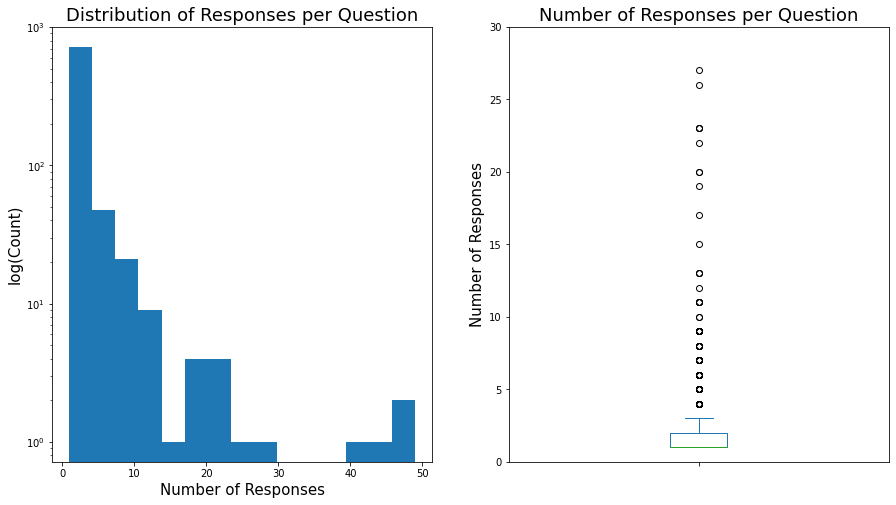

In [ ]:
# Distribution of number of responses
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
all_chat.groupby("questionID").agg("count")["questionLink"].plot.hist(bins=15, ax=axs[0], logy=True)
axs[0].set_title("Distribution of Responses per Question", fontsize=18)
axs[0].set_ylabel("log(Count)", fontsize=15)
axs[0].set_xlabel("Number of Responses", fontsize=15)


# Number of responses
all_chat.groupby("questionID").agg("count")["questionLink"].plot.box(ax=axs[1])
axs[1].set_title("Number of Responses per Question", fontsize=18)
axs[1].set_ylabel("Number of Responses", fontsize=15)
axs[1].set_xticklabels("")
axs[1].set_ylim([0, 30])


We will convert this dataset in a way that every response row will contain **n** previous responses as a context. For our purposes seven previous responses will be enough.

In [ ]:
contexted = []

n = 7

for i in range(n, len(all_chat['answerText'])):
  row = []
  prev = i - 1 - n # we additionally substract 1, so row will contain current responce and 7 previous responces  
  for j in range(i, prev, -1):
    row.append(all_chat['answerText'][j])
  contexted.append(row)  

In [ ]:
len(contexted)

2122

In [ ]:
columns = ['response', 'context'] 
columns = columns + ['context/'+str(i) for i in range(n-1)]
columns

['response',
 'context',
 'context/0',
 'context/1',
 'context/2',
 'context/3',
 'context/4',
 'context/5']

In [ ]:
df = pd.DataFrame.from_records(contexted, columns=columns)
df.head(5)

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
0,That is intense. Depression is a liar. Sometim...,You are exhibiting some specific traits of a p...,"Heck, sure thing, hun!Feelings of 'depression'...",I first want to let you know that you are not ...,Therapy is essential for those that are feelin...,First thing I'd suggest is getting the sleep y...,"Hello, and thank you for your question and see...","If everyone thinks you're worthless, then mayb..."
1,It sounds like you may be putting yourself las...,That is intense. Depression is a liar. Sometim...,You are exhibiting some specific traits of a p...,"Heck, sure thing, hun!Feelings of 'depression'...",I first want to let you know that you are not ...,Therapy is essential for those that are feelin...,First thing I'd suggest is getting the sleep y...,"Hello, and thank you for your question and see..."
2,It must be really difficult to experience what...,It sounds like you may be putting yourself las...,That is intense. Depression is a liar. Sometim...,You are exhibiting some specific traits of a p...,"Heck, sure thing, hun!Feelings of 'depression'...",I first want to let you know that you are not ...,Therapy is essential for those that are feelin...,First thing I'd suggest is getting the sleep y...
3,"People who feel worthless were, in one way or ...",It must be really difficult to experience what...,It sounds like you may be putting yourself las...,That is intense. Depression is a liar. Sometim...,You are exhibiting some specific traits of a p...,"Heck, sure thing, hun!Feelings of 'depression'...",I first want to let you know that you are not ...,Therapy is essential for those that are feelin...
4,I'm sorry to hear you're feeling this intense ...,"People who feel worthless were, in one way or ...",It must be really difficult to experience what...,It sounds like you may be putting yourself las...,That is intense. Depression is a liar. Sometim...,You are exhibiting some specific traits of a p...,"Heck, sure thing, hun!Feelings of 'depression'...",I first want to let you know that you are not ...


Split our dataset into a training and test parts.

In [ ]:
trn_df, val_df = train_test_split(df, test_size = 0.1)
trn_df.head()

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
1590,"The simplest answer is that love feels good, o...",People often care deeply for those whom they l...,I'm glad you recognize your own best interest ...,Open and honest communication can go a long wa...,Do you know why your girlfriend doesn't believ...,We women really do tend to struggle with the c...,A rare topic & likely extremely troublesome fo...,You're right that long-distance relationships ...
1031,Anger does have its place. When anger is expe...,Yes you can.. If you cannot control your temp...,"Well, yes, of course it scares them. They see...","Anger is a normal emotion, no different than j...",Must you keep this roommate in your life?If yo...,You must be feeling frustrated about how to re...,Awareness is the first step. Now that you kno...,Meditation may be able to assist you in dealin...
1589,People often care deeply for those whom they l...,I'm glad you recognize your own best interest ...,Open and honest communication can go a long wa...,Do you know why your girlfriend doesn't believ...,We women really do tend to struggle with the c...,A rare topic & likely extremely troublesome fo...,You're right that long-distance relationships ...,You're wise to be aware of possible changes to...
1548,I would first suggest you sitting down with hi...,I'm sorry you have tension between you and you...,My empathy goes out to you. Relationships are ...,One way to make good use of the situation you ...,"Hi Montgomery, Your first sentence says it all...",The basic guideline for relationship satisfact...,Attraction is important but sometimes over-rat...,"Well, as disappointed as you may very well fee..."
1408,It seems like you are going trough stages of g...,"I don't know how old you are, but depending on...",It sounds like you are hating some of the thin...,Breaking the patterns of relating to family me...,You could be protective because of things that...,It's hard to tell from the way you described i...,Have you ever tried talking with her about thi...,"Hello, and thank you for your question. This i..."


Now will convert our dataset in a format suitable for our model. Basically we will concatenate responses in one string for each row (additionally we will add special 'end of string' token between responses, so the model will understand end of each response in a string).  

In [ ]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [ ]:
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [ ]:
def train(args, train_dataset: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization if in use)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0.0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to global_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = float(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of the model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
# Main runner

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [ ]:
main(trn_df, val_df)

## Chatting with  SelfAi

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
model = AutoModelWithLMHead.from_pretrained('microsoft/DialoGPT-small')

def predict(input, history=[]):
    # tokenize the new input sentence
    new_user_input_ids = tokenizer.encode(input + tokenizer.eos_token, return_tensors='pt')

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([torch.LongTensor(history), new_user_input_ids], dim=-1)

    # generate a response 
    history = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id).tolist()

    # convert the tokens to text, and then split the responses into lines
    response = tokenizer.decode(history[0]).split("<|endoftext|>")
    response = [(response[i], response[i+1]) for i in range(0, len(response)-1, 2)]  # convert to tuples of list
    return response, history
  
   

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

In [ ]:
import gradio as gr

gr.Interface(fn=predict,
             inputs=["text", "state"],
             outputs=["chatbot", "state"]).launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>